# WORKSHOP 002 - NOTEBOOK #2


## Exploratory Data Analysis (EDA) on the Grammys Dataset

In [1]:
pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import sys


try:
    os.chdir("../")  
    print("Directorio de trabajo cambiado a:", os.getcwd())
except FileNotFoundError:
    print("No se pudo cambiar el directorio, verifica la ruta.")

project_root = os.path.abspath(os.path.join(os.getcwd()))
if project_root not in sys.path:
    sys.path.append(project_root)
    
print("sys.path actualizado. Directorio base:", project_root)


Directorio de trabajo cambiado a: /home/juanjoslo/etl/workshop-2
sys.path actualizado. Directorio base: /home/juanjoslo/etl/workshop-2


In [3]:
from src.db.db_operations import creating_engine, disposing_engine
from collections import Counter

import re
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

# Reading the data

In [4]:
engine = creating_engine()

10/04/2025 09:18:41 AM Engine created. You can now connect to the database.


In [5]:
try:
    query = "SELECT * FROM grammys LIMIT 5;"
    df_check = pd.read_sql(query, engine)
    print("Vista previa de la tabla 'grammys':")
    display(df_check)
except Exception as e:
    print("Error al consultar la tabla 'grammys':", e)

Vista previa de la tabla 'grammys':


,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner
0,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Bad Guy,Billie Eilish,"Finneas O'Connell, producer; Rob Kinelski & Fi...",https://www.grammy.com/sites/com/files/styles/...,True
1,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,"Hey, Ma",Bon Iver,"BJ Burton, Brad Cook, Chris Messina & Justin V...",https://www.grammy.com/sites/com/files/styles/...,True
2,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,7 rings,Ariana Grande,"Charles Anderson, Tommy Brown, Michael Foster ...",https://www.grammy.com/sites/com/files/styles/...,True
3,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Hard Place,H.E.R.,"Rodney “Darkchild” Jerkins, producer; Joseph H...",https://www.grammy.com/sites/com/files/styles/...,True
4,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Talk,Khalid,"Disclosure & Denis Kosiak, producers; Ingmar C...",https://www.grammy.com/sites/com/files/styles/...,True


In [6]:
grammys_data = pd.read_sql_table("grammys", engine)
grammys_data.head()

disposing_engine(engine)

10/04/2025 09:18:47 AM Engine disposed.


## Data preparation

### Reviewing the dataset

The Grammy dataset contains a total of 4,810 entries with 10 columns. The columns provide the following information:

**String columns (object type):**

- **title**: Title of the Grammy nomination.
- **published_at**: Date the nomination was published.
- **updated_at**: Date the nomination was last updated.
- **category**: The Grammy category.
- **nominee**: The person or group nominated.
- **artist**: The artist involved (if applicable).
- **workers**: People involved in the production.
- **img**: URL for an image related to the nomination.

**Numerical column (int64 type):**

- **year**: The year of the Grammy nomination.

**Boolean column (bool type):**

- **winner**: Indicates if the nominee won the Grammy.



In [7]:
df = grammys_data.copy()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4810 entries, 0 to 4809
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          4810 non-null   int64 
 1   title         4810 non-null   object
 2   published_at  4810 non-null   object
 3   updated_at    4810 non-null   object
 4   category      4810 non-null   object
 5   nominee       4804 non-null   object
 6   artist        2970 non-null   object
 7   workers       2620 non-null   object
 8   img           3443 non-null   object
 9   winner        4810 non-null   bool  
dtypes: bool(1), int64(1), object(8)
memory usage: 343.0+ KB


#### Checking the unique and null values

In [9]:
df.nunique()

year              62
title             62
published_at       4
updated_at        10
category         638
nominee         4131
artist          1658
workers         2366
img             1463
winner             1
dtype: int64

In [10]:
df.isnull().sum()

year               0
title              0
published_at       0
updated_at         0
category           0
nominee            6
artist          1840
workers         2190
img             1367
winner             0
dtype: int64

### Drop Columns

#### winner Column

In [11]:

df["winner"].value_counts()

winner
True    4810
Name: count, dtype: int64

In [12]:
df.rename(columns={"winner": "is_nominated"}, inplace=True)

#### Image column


In [13]:
df.loc[0, "img"]

'https://www.grammy.com/sites/com/files/styles/artist_circle/public/muzooka/Billie%2BEilish/Billie%2520Eilish_1_1_1594138954.jpg?itok=3-71Dfxh'

#### Published At and Updated At column

In [14]:
df["published_at"].value_counts()

published_at
2017-11-28T00:03:45-08:00    4205
2020-05-19T05:10:28-07:00     433
2018-12-06T23:48:49-08:00      86
2018-05-22T03:08:24-07:00      86
Name: count, dtype: int64

In [15]:
df["updated_at"].value_counts()

updated_at
2019-09-10T01:08:19-07:00    778
2019-09-10T01:06:11-07:00    754
2019-09-10T01:07:37-07:00    713
2019-09-10T01:06:59-07:00    681
2019-09-10T01:11:09-07:00    658
2019-09-10T01:09:02-07:00    554
2020-05-19T05:10:28-07:00    433
2017-11-28T00:03:45-08:00    108
2020-09-01T12:16:40-07:00     83
2019-09-10T01:11:48-07:00     48
Name: count, dtype: int64

#### remove unnecessary columns

In [16]:
df = df.drop(columns=["published_at", "updated_at", "img"])

In [17]:
df.head()

,year,title,category,nominee,artist,workers,is_nominated
0,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Bad Guy,Billie Eilish,"Finneas O'Connell, producer; Rob Kinelski & Fi...",True
1,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,"Hey, Ma",Bon Iver,"BJ Burton, Brad Cook, Chris Messina & Justin V...",True
2,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,7 rings,Ariana Grande,"Charles Anderson, Tommy Brown, Michael Foster ...",True
3,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Hard Place,H.E.R.,"Rodney “Darkchild” Jerkins, producer; Joseph H...",True
4,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Talk,Khalid,"Disclosure & Denis Kosiak, producers; Ingmar C...",True


### Null Values

#### Nominee

In [18]:
df.loc[df["nominee"].isna()]

,year,title,category,nominee,artist,workers,is_nominated
2274,2000,43rd Annual GRAMMY Awards (2000),"Remixer of the Year, Non-Classical",None,None,None,True
2372,1999,42nd Annual GRAMMY Awards (1999),"Remixer Of The Year, Non-Classical",None,None,None,True
2464,1998,41st Annual GRAMMY Awards (1998),"Remixer Of The Year, Non-classical",None,None,None,True
2560,1997,40th Annual GRAMMY Awards (1997),"Remixer Of The Year, Non-Classical",None,None,None,True
4527,1965,8th Annual GRAMMY Awards (1965),Best New Country & Western Artist,None,None,None,True
4574,1964,7th Annual GRAMMY Awards (1964),Best New Country & Western Artist Of 1964,None,None,None,True


In [19]:
df = df.dropna(subset=["nominee"])
df.loc[df["nominee"].isna()]

,year,title,category,nominee,artist,workers,is_nominated


#### Artist and Workers

In [20]:
both_null_values = df.loc[df["artist"].isna() & df["workers"].isna()]
both_null_values.head()

,year,title,category,nominee,artist,workers,is_nominated
24,2019,62nd Annual GRAMMY Awards (2019),Best New Artist,Billie Eilish,None,None,True
25,2019,62nd Annual GRAMMY Awards (2019),Best New Artist,Black Pumas,None,None,True
26,2019,62nd Annual GRAMMY Awards (2019),Best New Artist,Lil Nas X,None,None,True
27,2019,62nd Annual GRAMMY Awards (2019),Best New Artist,Lizzo,None,None,True
28,2019,62nd Annual GRAMMY Awards (2019),Best New Artist,Maggie Rogers,None,None,True


#### category

In [21]:
both_null_values["category"].value_counts()

category
Best New Artist                                                                              50
Producer Of The Year, Classical                                                              22
Producer Of The Year, Non-Classical                                                          22
Classical Producer Of The Year                                                               18
Producer Of The Year (Non-Classical)                                                         10
Producer Of The Year                                                                         10
Best New Artist Of The Year                                                                   9
Best Classical Vocal Soloist Performance                                                      7
Best Classical Performance - Instrumental Soloist Or Soloists (With Or Without Orchestra)     4
Best Classical Vocal Performance                                                              4
Best Small Ensemble Performance

In [22]:
categories = [
    "Best Classical Vocal Soloist Performance",
    "Best Classical Vocal Performance",
    "Best Small Ensemble Performance (With Or Without Conductor)",
    "Best Classical Performance - Instrumental Soloist Or Soloists (With Or Without Orchestra)",
    "Most Promising New Classical Recording Artist",
    "Best Classical Performance - Vocal Soloist (With Or Without Orchestra)",
    "Best New Classical Artist",
    "Best Classical Vocal Soloist",
    "Best Performance - Instrumental Soloist Or Soloists (With Or Without Orchestra)",
    "Best Classical Performance - Vocal Soloist"
]

both_filtered = both_null_values[both_null_values["category"].isin(categories)]
both_filtered.head()

,year,title,category,nominee,artist,workers,is_nominated
2382,1999,42nd Annual GRAMMY Awards (1999),Best Small Ensemble Performance (With Or Witho...,"Colors Of Love - Works Of Thomas, Stucky, Tave...",None,None,True
2475,1998,41st Annual GRAMMY Awards (1998),Best Small Ensemble Performance (With Or Witho...,Reich: Music For 18 Musicians,None,None,True
2570,1997,40th Annual GRAMMY Awards (1997),Best Small Ensemble Performance (With Or Witho...,"Hindemith: Kammermusik No. 1 With Finale 1921,...",None,None,True
2571,1997,40th Annual GRAMMY Awards (1997),Best Classical Vocal Performance,"An Italian Songbook - Works Of Bellini, Donize...",None,None,True
2658,1996,39th Annual GRAMMY Awards (1996),Best Small Ensemble Performance (With Or Witho...,Boulez: ...Explosante-Fixe...,None,None,True


In [23]:
both_null_values = both_null_values.drop(both_filtered.index, axis=0)
df = df.drop(both_filtered.index, axis=0)

In [24]:
df.shape

(4776, 7)

In [25]:
df.loc[both_null_values.index, "artist"] = both_null_values["nominee"]

In [26]:
df.loc[df["artist"].isna() & df["workers"].isna()]

,year,title,category,nominee,artist,workers,is_nominated


#### nominee & artist

In [27]:
artist_null = df.loc[df["artist"].isna()]
artist_null.shape

(1654, 7)

In [28]:
artist_null_sample = artist_null.head()
artist_null_sample

,year,title,category,nominee,artist,workers,is_nominated
16,2019,62nd Annual GRAMMY Awards (2019),Song Of The Year,Bad Guy,None,"Billie Eilish O'Connell & Finneas O'Connell, s...",True
17,2019,62nd Annual GRAMMY Awards (2019),Song Of The Year,Always Remember Us This Way,None,"Natalie Hemby, Lady Gaga, Hillary Lindsey & Lo...",True
18,2019,62nd Annual GRAMMY Awards (2019),Song Of The Year,Bring My Flowers Now,None,"Brandi Carlile, Phil Hanseroth, Tim Hanseroth ...",True
19,2019,62nd Annual GRAMMY Awards (2019),Song Of The Year,Hard Place,None,"Ruby Amanfu, Sam Ashworth, D. Arcelious Harris...",True
20,2019,62nd Annual GRAMMY Awards (2019),Song Of The Year,Lover,None,"Taylor Swift, songwriter (Taylor Swift)",True


In [29]:
for i in artist_null_sample.index:
    print(artist_null_sample.loc[i, "workers"])

Billie Eilish O'Connell & Finneas O'Connell, songwriters (Billie Eilish)
Natalie Hemby, Lady Gaga, Hillary Lindsey & Lori McKenna, songwriters (Lady Gaga)
Brandi Carlile, Phil Hanseroth, Tim Hanseroth & Tanya Tucker, songwriters (Tanya Tucker)
Ruby Amanfu, Sam Ashworth, D. Arcelious Harris, H.E.R. & Rodney Jerkins, songwriters (H.E.R.)
Taylor Swift, songwriter (Taylor Swift)


In [30]:
def extract_artist(workers):
    match = re.search(r'\((.*?)\)', workers)
    if match:
        return match.group(1)
    return None

df["artist"] = (df.apply
    (lambda row:
        extract_artist(row["workers"])
        if pd.isna(row["artist"])
            else row["artist"], axis=1))

In [31]:
df.iloc[16:20]

,year,title,category,nominee,artist,workers,is_nominated
16,2019,62nd Annual GRAMMY Awards (2019),Song Of The Year,Bad Guy,Billie Eilish,"Billie Eilish O'Connell & Finneas O'Connell, s...",True
17,2019,62nd Annual GRAMMY Awards (2019),Song Of The Year,Always Remember Us This Way,Lady Gaga,"Natalie Hemby, Lady Gaga, Hillary Lindsey & Lo...",True
18,2019,62nd Annual GRAMMY Awards (2019),Song Of The Year,Bring My Flowers Now,Tanya Tucker,"Brandi Carlile, Phil Hanseroth, Tim Hanseroth ...",True
19,2019,62nd Annual GRAMMY Awards (2019),Song Of The Year,Hard Place,H.E.R.,"Ruby Amanfu, Sam Ashworth, D. Arcelious Harris...",True


In [32]:
df.isna().sum()

year               0
title              0
category           0
nominee            0
artist           288
workers         2156
is_nominated       0
dtype: int64

In [33]:
artist_null = df[df['artist'].isna()]
artist_null.head()

,year,title,category,nominee,artist,workers,is_nominated
163,2015,58th Annual GRAMMY Awards (2015),Best Contemporary Classical Composition,Paulus: Prayers & Remembrances,None,"Stephen Paulus, composer",True
164,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,Sozinho,None,"Randy Brecker, soloist",True
165,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,Elsewhere,None,"Melissa Aldana, soloist",True
166,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,Tomorrow Is The Question,None,"Julian Lage, soloist",True
167,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,The Windup,None,"Branford Marsalis, soloist",True


In [34]:
artist_index = artist_null.index

In [35]:
roles = (artist_null["workers"]
         .dropna()
         .apply(
             lambda x: 
                 [role.strip() 
                  for role in re.split(r'[;,]', x)[1:]]))

roles_flat = ([role 
               for sublist in roles 
                for role in sublist])

role_counts = Counter(roles_flat)

role_counts.most_common()

[('artist', 80),
 ('producer', 73),
 ('soloist', 63),
 ('composer', 45),
 ('artists', 34),
 ('conductor', 27),
 ('engineer', 19),
 ('songwriters', 13),
 ('engineer/mixer', 10),
 ('producers', 9),
 ('Andreas Neubronner', 6),
 ('Tim Handley', 5),
 ('ensembles', 5),
 ('James Mallinson', 5),
 ('Thomas Frost', 4),
 ('Kirk Franklin', 3),
 ('songwriter', 3),
 ('soloists', 3),
 ('Karl-August Naegler', 3),
 ('Jonathan Allen', 2),
 ('John Newton', 2),
 ('engineers/mixers', 2),
 ('Christopher Alder', 2),
 ('Judith Sherman', 2),
 ('Adam Abeshouse', 2),
 ('Michelle DeYoung', 2),
 ('Hans Weber', 2),
 ('Robert Woods', 2),
 ('Lynn Harrell & Itzhak Perlman', 2),
 ('Artur Rubinstein & Henryk Szeryng', 2),
 ('David Harvey', 2),
 ('Thomas Z. Shepard', 2),
 ('Gregor Piatigorsky & William Primrose', 2),
 ('Bryan Fowler', 1),
 ('Gloria Gaynor & Chris Stevens', 1),
 ('Tony Brown', 1),
 ('Brandon Lake', 1),
 ('Tasha Cobbs Leonard & Nate Moore', 1),
 ('Josh Kerr', 1),
 ('Jordan Reynolds', 1),
 ('Joel Smallbone'

In [36]:
roles_of_interest = ["artist",
                     "artists",
                     "composer",
                     "conductor",
                     "conductor/soloist",
                     "choir director",
                     "chorus master",
                     "graphic designer",
                     "soloist",
                     "soloists",
                     "ensembles"]

In [37]:
def move_workers_to_artist(row):
    if pd.isna(row["artist"]):
        workers = row["workers"]
        if not re.search(r'[;,]', workers):
            return workers
    return row["artist"]

df["artist"] = df.apply(move_workers_to_artist, axis=1)

In [38]:
new_artist = df.loc[artist_index]
new_artist.loc[[192, 193, 402, 403]]

,year,title,category,nominee,artist,workers,is_nominated
192,2019,62nd Annual GRAMMY Awards (2019),Best Gospel Performance/Song,See The Light,Travis Greene Featuring Jekalyn Carr,Travis Greene Featuring Jekalyn Carr,True
193,2019,62nd Annual GRAMMY Awards (2019),Best Gospel Performance/Song,Speak The Name,Koryn Hawthorne Featuring Natalie Grant,Koryn Hawthorne Featuring Natalie Grant,True
402,2019,62nd Annual GRAMMY Awards (2019),Best Chamber Music/Small Ensemble Performance,Shaw: Orange,Attacca Quartet,Attacca Quartet,True
403,2019,62nd Annual GRAMMY Awards (2019),Best Chamber Music/Small Ensemble Performance,Cerrone: The Pieces That Fall To Earth,Christopher Rountree & Wild Up,Christopher Rountree & Wild Up,True


In [39]:
artist_null = df[df["artist"].isna()]
artist_index = artist_null.index

#### Semicolons

In [40]:
def extract_artists_before_semicolon(workers, roles):
    parts = workers.split(';')
    first_part = parts[0].strip()
    if ',' not in first_part and not any(role in first_part for role in roles):
        return first_part
    return None

df["artist"] = df.apply(
    lambda row: extract_artists_before_semicolon(row["workers"], roles_of_interest) if pd.isna(row["artist"]) else row["artist"],
    axis=1
)

In [41]:
new_artists = df.loc[artist_index]
new_artists.loc[[190, 191, 196, 197]]

,year,title,category,nominee,artist,workers,is_nominated
190,2019,62nd Annual GRAMMY Awards (2019),Best Gospel Performance/Song,Love Theory,Kirk Franklin,"Kirk Franklin; Kirk Franklin, songwriter",True
191,2019,62nd Annual GRAMMY Awards (2019),Best Gospel Performance/Song,Talkin' 'Bout Jesus,Gloria Gaynor Featuring Yolanda Adams,Gloria Gaynor Featuring Yolanda Adams; Bryan F...,True
196,2019,62nd Annual GRAMMY Awards (2019),Best Contemporary Christian Music Performance/...,Only Jesus,Casting Crowns,"Casting Crowns; Mark Hall, Bernie Herms & Matt...",True
197,2019,62nd Annual GRAMMY Awards (2019),Best Contemporary Christian Music Performance/...,Haven't Seen It Yet,Danny Gokey,"Danny Gokey; Danny Gokey, Ethan Hulse & Colby ...",True


In [42]:
artist_null = df[df["artist"].isna()]
artist_index = artist_null.index

#### Commas

In [43]:
def extract_roles_based_on_interest(workers, roles):
    pattern = r'([^;]+)\s*(?:,\s*(?:' + '|'.join(roles) + r'))'
    matches = re.findall(pattern, workers)
    return ", ".join(matches).strip() if matches else None

df["artist"] = df.apply(
    lambda row: extract_roles_based_on_interest(row["workers"], roles_of_interest) if pd.isna(row["artist"]) else row["artist"],
    axis=1
)

In [44]:
new_artists = df.loc[artist_index]
new_artists.head()

,year,title,category,nominee,artist,workers,is_nominated
163,2015,58th Annual GRAMMY Awards (2015),Best Contemporary Classical Composition,Paulus: Prayers & Remembrances,Stephen Paulus,"Stephen Paulus, composer",True
164,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,Sozinho,Randy Brecker,"Randy Brecker, soloist",True
165,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,Elsewhere,Melissa Aldana,"Melissa Aldana, soloist",True
166,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,Tomorrow Is The Question,Julian Lage,"Julian Lage, soloist",True
167,2019,62nd Annual GRAMMY Awards (2019),Best Improvised Jazz Solo,The Windup,Branford Marsalis,"Branford Marsalis, soloist",True


In [45]:
df.isna().sum()

year               0
title              0
category           0
nominee            0
artist             5
workers         2156
is_nominated       0
dtype: int64

In [46]:
artist_null = df.loc[df["artist"].isnull()]
artist_null

,year,title,category,nominee,artist,workers,is_nominated
777,2015,58th Annual GRAMMY Awards (2015),Best Chamber Music/Small Ensemble Performance,Filament,None,"Bryce Dessner, producer; Jonathan Low, engineer",True
861,2014,57th Annual GRAMMY Awards (2014),Best Chamber Music/Small Ensemble Performance,In 27 Pieces - The Hilary Hahn Encores,None,"Hilary Hahn & Andreas K. Meyer, producers; And...",True
1869,2004,47th Annual GRAMMY Awards (2004),Best Chamber Music Performance,Prokofiev (Arr. Pletnev): Cinderella - Suite F...,None,"Christian Gansch, producer; Rainer Maillard, e...",True
2182,2001,44th Annual GRAMMY Awards (2001),Best Small Ensemble Performance (with or witho...,"After Mozart - Raskatov, Silvestrov & Schnittke",None,"Gidon Kremer & Helmut Mühle, producers; Philip...",True
2285,2000,43rd Annual GRAMMY Awards (2000),Best Small Ensemble Performance (with or witho...,"Shadow Dances - Stravinsky Miniatures, Tango, ...",None,"Christian Gansch, producer; Wolf-Dieter Karwat...",True


In [47]:
df = df.dropna(subset=["artist"])

df = df.drop(columns=["workers"])

In [48]:
df.head()

,year,title,category,nominee,artist,is_nominated
0,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Bad Guy,Billie Eilish,True
1,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,"Hey, Ma",Bon Iver,True
2,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,7 rings,Ariana Grande,True
3,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Hard Place,H.E.R.,True
4,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Talk,Khalid,True


## Data Transformation


In [49]:
df["artist"].value_counts()

artist
(Various Artists)                                                   66
Various Artists                                                     43
Chicago Symphony Orchestra                                          29
John Williams                                                       24
Henry Mancini                                                       22
                                                                    ..
Siedah Garrett & Henry Krieger, songwriters (Jennifer Hudson)        1
(The Beatles)                                                        1
Original Broadway Cast With Jonathan Groff, Lea Michele & Others     1
Flight Of The Conchords                                              1
Roger Wagner                                                         1
Name: count, Length: 2463, dtype: int64

In [50]:
df["artist"] = df["artist"].replace({"(Various Artists)": "Various Artists"})

In [51]:
df['artist'].value_counts()

artist
Various Artists                                                      109
Chicago Symphony Orchestra                                            29
John Williams                                                         24
Henry Mancini                                                         22
Vladimir Horowitz                                                     20
                                                                    ... 
Fred Hammond                                                           1
Ricky Skaggs & The Whites                                              1
Israel And New Breed                                                   1
Aretha Franklin & Mary J. Blige (Featuring The Harlem Boys Choir)      1
Roger Wagner                                                           1
Name: count, Length: 2462, dtype: int64

In [59]:
df['artist'].to_csv('artists.csv', index=False)

## Data understanding

In [52]:
awarded_data = df.copy()

In [53]:
awarded_data["decade"] = (awarded_data["year"] // 10) * 10
awarded_data

,year,title,category,nominee,artist,is_nominated,decade
0,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Bad Guy,Billie Eilish,True,2010
1,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,"Hey, Ma",Bon Iver,True,2010
2,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,7 rings,Ariana Grande,True,2010
3,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Hard Place,H.E.R.,True,2010
4,2019,62nd Annual GRAMMY Awards (2019),Record Of The Year,Talk,Khalid,True,2010
...,...,...,...,...,...,...,...
4804,1958,1st Annual GRAMMY Awards (1958),Best Classical Performance - Orchestra,Gaiete Parisienne,Hollywood Bowl Orchestra,True,1950
4805,1958,1st Annual GRAMMY Awards (1958),Best Classical Performance - Instrumentalist (...,Tchaikovsky: Piano Concerto No. 1 In B Flat Mi...,Symphony Of The Air Orchestra,True,1950
4806,1958,1st Annual GRAMMY Awards (1958),Best Classical Performance - Instrumentalist (...,Segovia Golden Jubilee,Andres Segovia,True,1950
4807,1958,1st Annual GRAMMY Awards (1958),Best Classical Performance - Chamber Music (In...,Beethoven: Quartet 130,"Alvin Dinkin, Paul Shure, Eleanor Aller Slatki...",True,1950


In [54]:
df['artist'].to_csv('artists.csv', index=False, header=True)

#### Most Nominated Artists

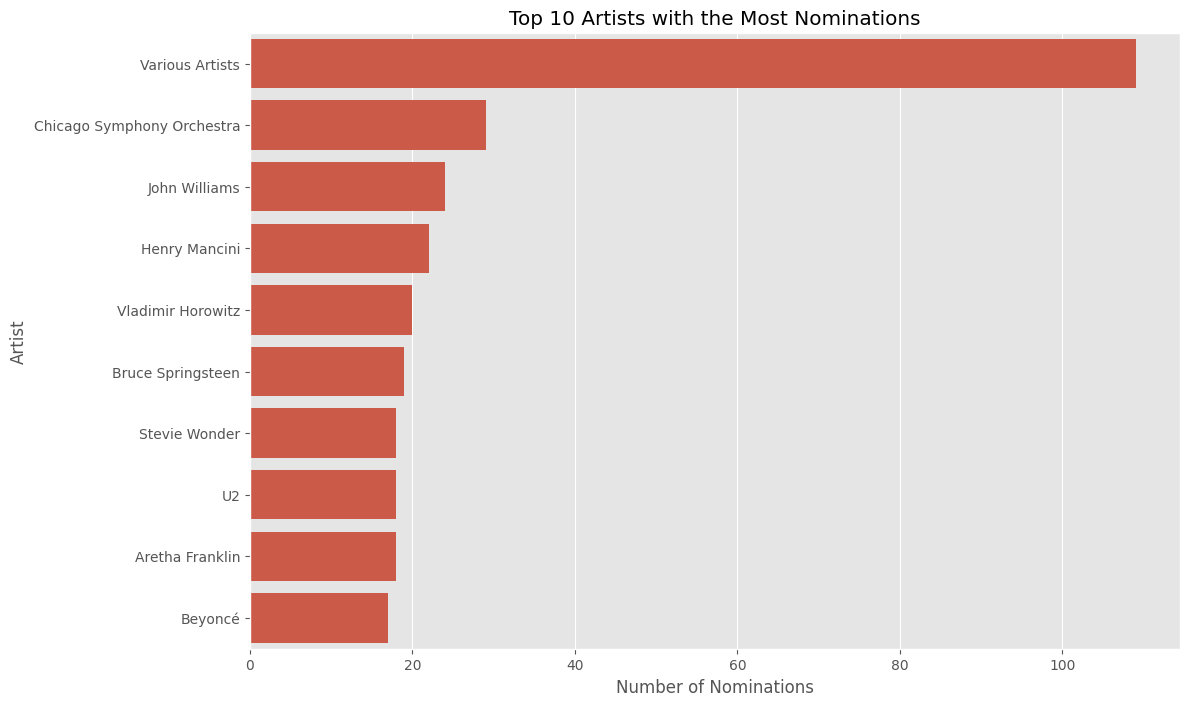

In [55]:
artist_nominations = awarded_data["artist"].value_counts().head(10)

plt.figure(figsize=(12, 8))

sns.barplot(x=artist_nominations.values,
            y=artist_nominations.index)

plt.title("Top 10 Artists with the Most Nominations")
plt.xlabel("Number of Nominations")
plt.ylabel("Artist")

plt.show()

### Top 10 Categories with the Most Artist Nominations

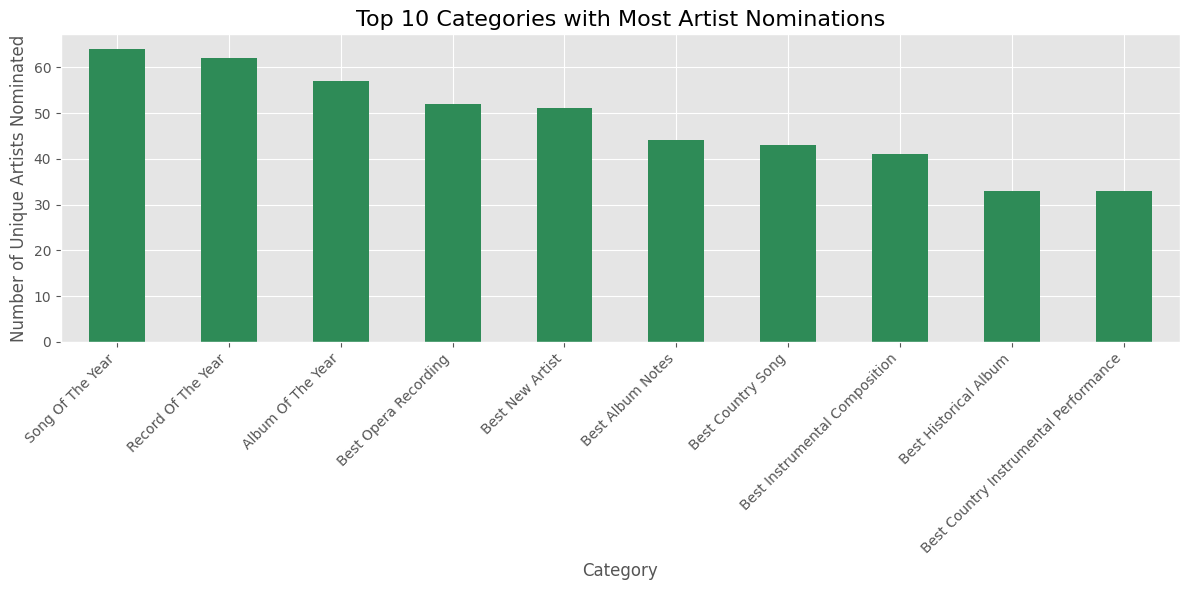

In [56]:
category_artist_nominations = awarded_data.groupby('category')['artist'].nunique().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
category_artist_nominations.head(10).plot(kind='bar', color='seagreen')
plt.title('Top 10 Categories with Most Artist Nominations', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Unique Artists Nominated', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Nominations per Decade

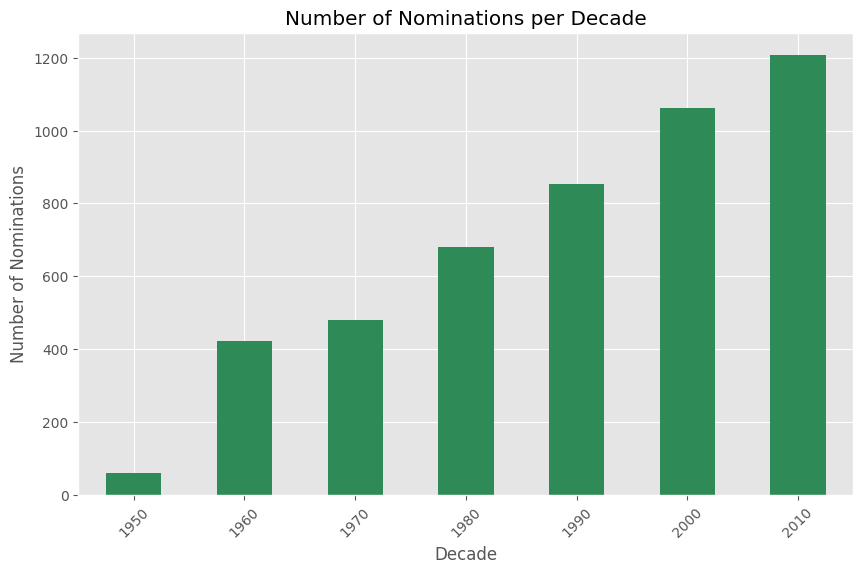

In [57]:
nominations_per_decade = awarded_data["decade"].value_counts().sort_index()

plt.figure(figsize=(10, 6))

nominations_per_decade.plot(kind="bar", color="seagreen")

plt.title("Number of Nominations per Decade")
plt.xlabel("Decade")
plt.ylabel("Number of Nominations")

plt.xticks(rotation=45)

plt.show()

### Most Nominated Artists per Decade

10/04/2025 09:18:54 AM Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
10/04/2025 09:18:54 AM Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


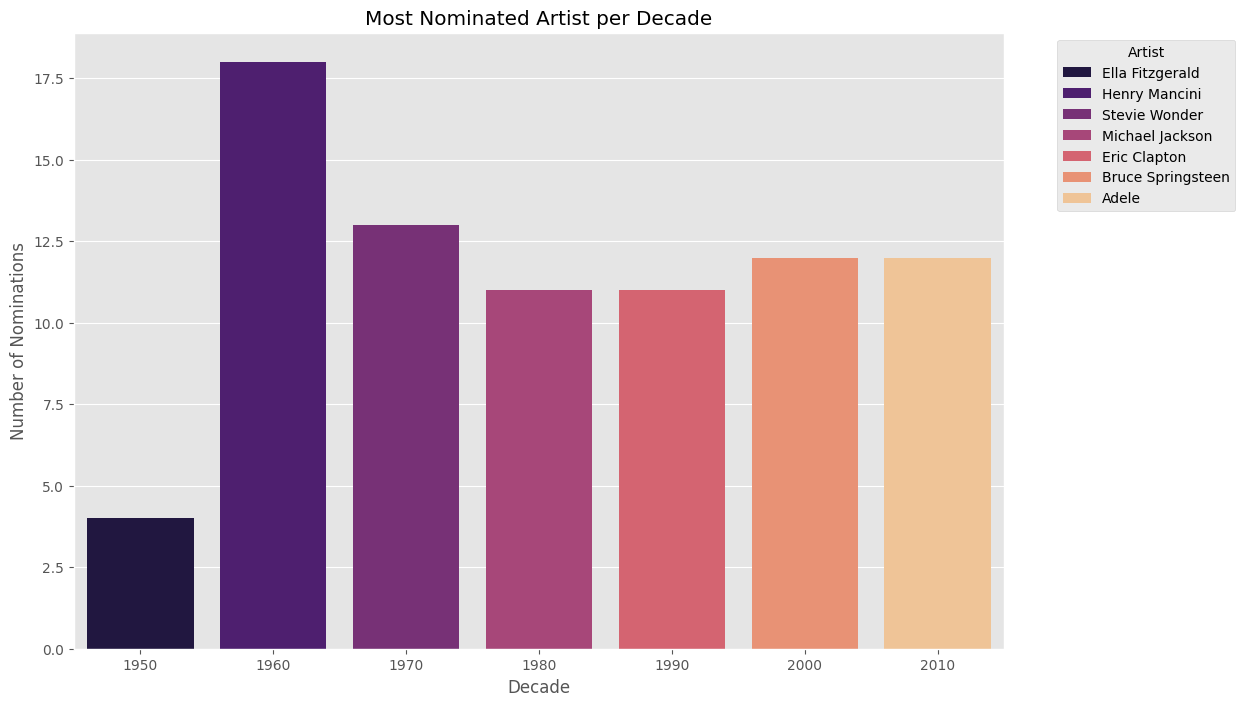

In [58]:
filtered_awarded_data = awarded_data[awarded_data["artist"] != "Various Artists"]

most_nominated_per_decade = (filtered_awarded_data.groupby(["decade", "artist"])
                             .size()
                             .reset_index(name="count")
                             .sort_values(["decade", "count"], ascending=[True, False])
                             .drop_duplicates(subset=["decade"]))

plt.figure(figsize=(12, 8))

sns.barplot(x="decade",
            y="count",
            hue="artist",
            dodge=False,
            data=most_nominated_per_decade,
            palette="magma")

plt.title("Most Nominated Artist per Decade")
plt.xlabel("Decade")
plt.ylabel("Number of Nominations")
plt.legend(title="Artist", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()

# Conclusions




**Data Cleaning and Preparation:**

- The dataset required extensive cleaning, especially when handling missing values in the **artist** and **workers** columns.
- I decided to remove unnecessary columns like **published_at**, **updated_at**, and **img**, which helped streamline the dataset.
- I renamed the **winner** column to **is_nominated** to better represent the data, as I was focusing on the nominations rather than just the winners.

**Handling Missing Values:**

- I used different strategies to handle missing data, including dropping rows where the **nominee** was missing and imputing missing **artist** data from the **workers** column.
- I also identified specific patterns in the **workers** column and used them to fill in missing **artist** information, ensuring consistency across the dataset.

**Data Transformation:**

- I standardized the **artist** column by replacing inconsistent entries like "(Various Artists)" with a consistent label "Various Artists."
- To make the analysis over time easier, I added a new column, **decade**, which allowed me to group the data by decades and compare trends over different periods.

**Key Insights:**

- The number of Grammy nominations has been steadily increasing over the years, with a sharp rise in the 2010s, reflecting a growth in both the number of nominations and categories.
- Certain artists have dominated nominations in specific decades, reflecting shifts in musical trends and the growing popularity of specific artists over time.
- **Various Artists**, representing collaborative albums, received the highest number of nominations, indicating how popular group projects have become over the years.
- The Grammy categories have evolved significantly, particularly in 2011-2012, when there was a major reorganization to simplify and modernize the awards.

**Visualization:**

- I used **bar plots** and **line plots** to visualize the number of nominations per decade, highlight the most nominated artists of each decade, and track the evolution of Grammy categories.
- These visualizations gave me clear insights into the trends and patterns in the Grammy Awards data, helping me see how things have changed over time.

### Implications:

- **Trends in the Industry**: The visualizations show how the Grammy Awards have evolved over time, reflecting changes in the music industry and shifting listener preferences. The increased number of nominations and categories indicates the growing diversity of the music landscape.
  
- **Strategic Insights**: The insights I've gained can be useful for artists, producers, and marketers to align their future projects with the most prominent categories and trends, increasing their chances of being nominated.

- **Expansion and Diversification**: The expansion of categories and the rise of collaborations suggest that the Grammy Awards will continue evolving to better reflect the broad spectrum of music genres and artist contributions.
